# Assessment 3: RNNs for stock price prediction

In [2]:
import sys, site
from pathlib import Path

################################# NOTE #################################
#  Please be aware that if colab installs the latest numpy and pyqlib  #
#  in this cell, users should RESTART the runtime in order to run the  #
#  following cells successfully.                                       #
########################################################################

try:
    import qlib
except ImportError:
    # install qlib
    ! pip install --upgrade numpy
    ! pip install pyqlib
    if "google.colab" in sys.modules:
        # The Google colab environment is a little outdated. We have to downgrade the pyyaml to make it compatible with other packages
        ! pip install pyyaml==5.4.1
    # reload
    site.main()

scripts_dir = Path.cwd().parent.joinpath("scripts")
if not scripts_dir.joinpath("get_data.py").exists():
    # download get_data.py script
    scripts_dir = Path("~/tmp/qlib_code/scripts").expanduser().resolve()
    scripts_dir.mkdir(parents=True, exist_ok=True)
    import requests

    with requests.get("https://raw.githubusercontent.com/microsoft/qlib/main/scripts/get_data.py", timeout=10) as resp:
        with open(scripts_dir.joinpath("get_data.py"), "wb") as fp:
            fp.write(resp.content)

In [3]:
## Dataset
import qlib
from qlib.constant import REG_US
from qlib.utils import exists_qlib_data, init_instance_by_config
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord
from qlib.utils import flatten_dict
## Data manioulation
import pandas as pd
import numpy as np
import datetime as dt
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## pytorch part
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [4]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

# Set the seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


Using device: cpu



## Step01: Data exploration

In [5]:
# use default data
# NOTE: need to download data from remote: python scripts/get_data.py qlib_data_cn --target_dir ~/.qlib/qlib_data/cn_data
# from qlib.config import REG_US
provider_uri = "~/.qlib/qlib_data/us_data"  # target_dir
if not exists_qlib_data(provider_uri):
    print(f"Qlib data is not found in {provider_uri}")
    sys.path.append(str(scripts_dir))
    from get_data import GetData

    GetData().qlib_data(target_dir=provider_uri, region=REG_US)
qlib.init(provider_uri=provider_uri, region=REG_US)

[21292:MainThread](2023-11-19 02:28:11,189) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[21292:MainThread](2023-11-19 02:28:11,198) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[21292:MainThread](2023-11-19 02:28:11,199) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/possa/.qlib/qlib_data/us_data')}


In [6]:
from qlib.data import D
# parameter selection
# index_list  = ['^GSPC','^IXIC','^DJI']
# index_list  = ['AAPL', 'MSFT']
# index_name  = ['Apple', 'Microsoft']
# index_list  = ['AAPL']
# index_name  = ['Apple']
# fields = ['$close', '$volume', '$open', '$high', '$low']

# df = D.features(D.instruments("all"), ["$close"], freq="day")
# inst = D.list_instruments(D.instruments(symbols ), freq="day", as_list=True) # show the selecting symbols 

# Fetch daily data for the indices
def set_df():
    # select the index & Fleids
    index_list  = ['^GSPC']
    # index_list  = ['AAPL', 'MSFT']
    # fields = ['$close', '$volume', '$open', '$high', '$low']
    fields = ['$close']
    # download dataset
    df = D.features(index_list , fields, freq='day')
    
    # manipulated the dataset
    df = df.reset_index()
    # df.columns = ['symbols','date','close','volume','open','high','low']
    df.columns = ['symbols','date','close']
    df = df.drop(columns='symbols')
    df.date = df.date.dt.date
    print(f"Period since {min(df.date)} to {max(df.date)}: {max(df.date) - min(df.date)}")
    df = df.set_index(['date'])
    df.index = pd.to_datetime(df.index)
    if not df.index.is_monotonic:
        df = df.sort_index()
    df = df.rename(columns={'close': 'value'})
    return df, index_list

df, index_list = set_df()

Period since 1999-12-31 to 2020-11-10: 7620 days, 0:00:00


In [7]:
df.tail(5)

,value
date,
2020-11-04,2.343672
2020-11-05,2.389280
2020-11-06,2.388593
2020-11-09,2.416539
2020-11-10,2.413157


### Exploratory Image analysis

In [8]:
import plotly.graph_objs as go
from plotly.offline import iplot

def plot_dataset(df, title):
    data = []
    value = go.Scatter(
        x=df.index,
        y=df.value,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [9]:
plot_dataset(df, title='title please added')

In [10]:
# features: lagging
def generate_time_lags(df, period):
    df_n = df.copy()
    # for n in range(1, n_lags + 1):
    for n in period:
        df_n[f"lag{n}"] = df_n["value"].shift(n)
    df_n = df_n.iloc[max(period):]
    return df_n

# features: encode the day features
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def onehot_encode(df, onehot_columns):
    ct = ColumnTransformer(
        [('onehot', OneHotEncoder(drop='first'), onehot_columns)],
        remainder='passthrough'
        )
    return ct.fit_transform(df)


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def onehot_encode_pd(df, cols):
    for col in cols:
        dummies = pd.get_dummies(df[col], prefix=col)
    
    return pd.concat([df, dummies], axis=1).drop(columns=cols)

# features: holidays
from datetime import date
import holidays

us_holidays = holidays.US()

def is_holiday(date):
    date = date.replace(hour = 0)
    return 1 if (date in us_holidays) else 0

def add_holiday_col(df, holidays):
    return df.assign(is_holiday = df.index.to_series().apply(is_holiday))

# combine feature
def add_feature(df):
    df = (
                df
                .assign(hour = df.index.hour)
                .assign(day = df.index.day)
                .assign(month = df.index.month)
                .assign(day_of_week = df.index.dayofweek)
                .assign(week_of_year=df.index.isocalendar().week)
              )
    df = generate_time_lags(df, [7,14,30,60])
    
    df = add_holiday_col(df, us_holidays)
    df = onehot_encode_pd(df, ['month','day','day_of_week','week_of_year'])
    return df

df_feature = add_feature(df)
df_feature
# print(df_feature.head(3))

,value,hour,lag7,lag14,lag30,lag60,is_holiday,week_of_year_1,week_of_year_2,week_of_year_3,...,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53
date,,,,,,,,,,,,,,,,,,,,,
2000-03-28,1.026190,0,0.996747,0.930202,0.946020,1.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-03-29,1.026728,0,0.991411,0.954017,0.954262,0.990451,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-03-30,1.012707,0,1.016757,0.949512,0.944475,0.952472,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-03-31,1.019963,0,1.021365,0.941719,0.944877,0.954303,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-04-03,1.024992,0,1.039544,0.925064,0.916175,0.955215,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-04,2.343672,0,2.314766,2.370829,2.203110,2.268974,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2020-11-05,2.389280,0,2.307762,2.371149,2.209692,2.300732,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2020-11-06,2.388593,0,2.226326,2.332428,2.244996,2.296022,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Step 03: Data splitting

In [11]:
# splitting criteria training 70%, validation 20% and testing 10%

def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def split_data(df, target_col):
    train_size = int(len(df) * 0.7)
    valid_size = int(len(df) * 0.2)
    
    # split for train / valid / test
    train_data = df[:train_size]
    valid_data = df[train_size:train_size + valid_size]
    test_data = df[train_size + valid_size:]
    
    print(f"Training size: {len(train_data)} period {train_data.index[0]} to {train_data.index[len(train_data)-1]} \nValidation size: {len(valid_data)} period {valid_data.index[0]} to {valid_data.index[len(valid_data)-1]}\ntest_data size: {len(test_data)} period {test_data.index[0]} to {test_data.index[len(test_data)-1]}")
    
    x_train, y_train = feature_label_split(train_data, target_col)
    x_valid, y_valid = feature_label_split(valid_data, target_col)
    x_test, y_test = feature_label_split(test_data, target_col)
    
    # return train_data,valid_data, test_data
    return x_train, y_train, x_valid, y_valid, x_test, y_test
    
    
# train_size = int(len(df) * 0.7)
# valid_size = int(len(df) * 0.2)

# train_data = df[:train_size]
# valid_data = df[train_size:train_size + valid_size]
# test_data = df[train_size + valid_size:]

# print(f"Training size: {len(train_data)} period {train_data.index[0]} to {train_data.index[len(train_data)-1]} \nValidation size: {len(valid_data)} period {valid_data.index[0]} to {valid_data.index[len(valid_data)-1]}\ntest_data size: {len(test_data)} period {test_data.index[0]} to {test_data.index[len(test_data)-1]}")

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_feature, 'value')

X_train

Training size: 3632 period 2000-03-28 00:00:00 to 2014-09-04 00:00:00 
Validation size: 1038 period 2014-09-05 00:00:00 to 2018-10-17 00:00:00
test_data size: 520 period 2018-10-18 00:00:00 to 2020-11-10 00:00:00


,hour,lag7,lag14,lag30,lag60,is_holiday,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,...,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53
date,,,,,,,,,,,,,,,,,,,,,
2000-03-28,0,0.996747,0.930202,0.946020,1.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-03-29,0,0.991411,0.954017,0.954262,0.990451,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-03-30,0,1.016757,0.949512,0.944475,0.952472,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-03-31,0,1.021365,0.941719,0.944877,0.954303,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-04-03,0,1.039544,0.925064,0.916175,0.955215,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-28,0,1.348715,1.314677,1.332734,1.312153,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-08-29,0,1.352057,1.318305,1.346415,1.320715,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-09-02,0,1.356046,1.316148,1.343291,1.326827,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Step 3: Data Preprocessing

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()
 
X_train, y_train, X_val, y_val, X_test, y_test    
    
scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [13]:
def create_dataset(dataset,time_step):
    X,y = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:i+time_step,0]
        X.append(a)
        y.append(dataset[i+time_step,0])
        
    # #RNN and LSTM takes 3D inputs, we need to change the shape of array to 3 dimensional.
    X_output = torch.tensor(np.array(X))
    X_output = X_output.reshape(X_output.shape[0],X_output.shape[1],1)
    Y_output = torch.tensor(np.array(y)).unsqueeze(dim=1)
    # return X_output,Y_output
    return torch.utils.data.TensorDataset(X_output, Y_output)

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

batch_size = 1
trainloader = torch.utils.data.DataLoader(
    # torch.utils.data.TensorDataset(X_train, y_train), 
    TensorDataset(train_features, train_targets),
    shuffle=True, 
    batch_size=batch_size,
    pin_memory = True
    )
valloader = torch.utils.data.DataLoader(
    TensorDataset(val_features, val_targets),
    batch_size=batch_size,
    shuffle=False,
    # num_workers=worker,
    pin_memory = True
    )
testloader = torch.utils.data.DataLoader(
    # create_dataset(test_data,20),
    TensorDataset(test_features, test_targets),
    batch_size=batch_size,
    shuffle=False,
    pin_memory = True
    )


## Step 04: Define the RNN Model

In [14]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()

        self.RNN = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers
        )
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.RNN(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state
rnn = RNN(input_size = 1, hidden_size = 32, num_layers = 2,  output_size = 1)
rnn    

RNN(
  (RNN): RNN(1, 32, num_layers=2)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

### Vanilla RNN

In [15]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

### Long Short-Term Memory (LSTM)

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

### Gated Recurrent Unit (GRU)

In [17]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [18]:
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

## Step 05: training model

### training function

In [19]:
import time
from tqdm import tqdm

## apply the dataloader
set_seed(1311)

def train_epoch(model, dataloader, criterion, optimizer, n_features = 1):
    model.train()
    
    # Initializing variable
    running_loss = 0.0
    total_train = 0
    
    for inputs, labels in tqdm(dataloader, desc='Training'):
        inputs = inputs.view([batch_size, -1, n_features]).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        total_train += labels.size(0)
        
    epoch_loss = running_loss / total_train
    return epoch_loss
    
def evaluate(model, dataloader, criterion, n_features = 1, be_test = False):
    model.eval()
    running_loss = 0.0
    total = 0
    
    # for test set prediction
    predictions = []
    values = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.view([batch_size, -1, n_features]).to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            loss = criterion(outputs.view(-1), labels)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            if be_test:
                predictions.append(outputs.to(device).detach().numpy())
                values.append(labels.to(device).detach().numpy())
    
    loss = running_loss / total
    if be_test:
        return loss, predictions, values
    return loss

def train_network(model, optimizer, criterion, scheduler, trainloader, valloader, testloader, num_epochs, input_dim, model_name, dataset):

    ## section00: setting path for save the model
    set_seed(1311)
    PATH = f'./model/{dataset}_{model_name}.pth'
    print('Model will be saved to:', PATH)
    print('Using device:', device, 'with seed: 1311')
    print()

    ## section01: Initialize variables
    best_val_loss = 100000  # to track the best validation accuracy
    # create set to collect the output
    history = {
        'train_loss': [],
        'val_loss': [],
        'test_loss': [],
        'best_model': [],
        'test_pred': [],
        'test_actual': [],
    }
    
     ## section02: Training and validation the model
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        train_loss = train_epoch(model, trainloader, criterion, optimizer,input_dim)
        val_loss = evaluate(model, valloader, criterion, input_dim)

        # Step the scheduler with the validation loss
        scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Save the model if it has improved on validation accuracy
        if best_val_loss > val_loss:
            print("check loss: ",best_val_loss,val_loss)
            best_val_loss = val_loss
            torch.save(model.state_dict(), PATH)
            print(f'Model improved and saved to {PATH}')
            
        # print epoch results
        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')
        
    print('Training complete. Evaluating on test set with the best model...')
    
    ## section03: Load the best model for final evaluation on test set
    best_model = model
    best_model.load_state_dict(torch.load(PATH))
    
    test_loss, history['test_pred'] , history['test_actual']  = evaluate(best_model, testloader, criterion, input_dim, True)
    # y_pred, h_State = best_model(torch.tensor(test_data))
    print(f'Test Loss: {test_loss:.4f}')
    # Add test results to history
    history['test_loss'] = test_loss
    history['best_model'] = best_model
    
    return history

def plot_loss(train_loss, val_loss):
    if isinstance(train_loss[0], torch.Tensor):
        train_loss = [x.cpu().numpy() for x in train_loss]
    if isinstance(val_loss[0], torch.Tensor):
        val_loss = [x.cpu().numpy() for x in val_loss]

    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()


### Standard setting

In [20]:
# Set up the model structure
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
dropout = 0.2
model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

# Set up the training hyperparameter
num_epochs = 50
learning_rate = 1e-5
weight_decay = 1e-3
momentum=0.9
dataset = index_list[0]


### Training with valinaRMM

Model will be saved to: ./model/^GSPC_rnn.pth
Using device: cpu with seed: 1311



Training:   0%|          | 0/3632 [00:00<?, ?it/s]c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning:

Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Training:   4%|▍         | 144/3632 [00:00<00:18, 191.13it/s]

Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1165.61it/s]


check loss:  100000 0.3936441266812341
Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 1/15, Train Loss: 0.0543, Val Loss: 0.3936, Time: 18.52s


Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1137.35it/s]


check loss:  0.3936441266812341 0.20179521189625724
Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 2/15, Train Loss: 0.0197, Val Loss: 0.2018, Time: 18.23s


Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1237.85it/s]


check loss:  0.20179521189625724 0.08683683302052506
Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 3/15, Train Loss: 0.0117, Val Loss: 0.0868, Time: 18.34s


Evaluating: 100%|██████████| 1038/1038 [00:01<00:00, 981.48it/s]


check loss:  0.08683683302052506 0.03310405387374668
Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 4/15, Train Loss: 0.0076, Val Loss: 0.0331, Time: 17.30s


Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1201.98it/s]


check loss:  0.03310405387374668 0.02439198078148159
Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 5/15, Train Loss: 0.0061, Val Loss: 0.0244, Time: 17.37s


Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1186.13it/s]


check loss:  0.02439198078148159 0.023373593547938058
Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 6/15, Train Loss: 0.0054, Val Loss: 0.0234, Time: 19.48s


Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1339.26it/s]


check loss:  0.023373593547938058 0.020327478471009353
Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 7/15, Train Loss: 0.0048, Val Loss: 0.0203, Time: 16.11s


Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1353.23it/s]


check loss:  0.020327478471009353 0.01761016857094532
Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 8/15, Train Loss: 0.0044, Val Loss: 0.0176, Time: 15.89s


Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1276.66it/s]


Epoch 9/15, Train Loss: 0.0042, Val Loss: 0.0196, Time: 18.07s


Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1408.32it/s]


check loss:  0.01761016857094532 0.013777271058345003
Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 10/15, Train Loss: 0.0040, Val Loss: 0.0138, Time: 15.60s


Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1642.29it/s]


Epoch 11/15, Train Loss: 0.0038, Val Loss: 0.0149, Time: 13.97s


Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1782.01it/s]


Epoch 12/15, Train Loss: 0.0036, Val Loss: 0.0140, Time: 13.00s


Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1885.48it/s]


Epoch 13/15, Train Loss: 0.0034, Val Loss: 0.0146, Time: 13.91s


Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1491.38it/s]


check loss:  0.013777271058345003 0.013184342047934698
Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 14/15, Train Loss: 0.0034, Val Loss: 0.0132, Time: 14.94s


Evaluating: 100%|██████████| 1038/1038 [00:01<00:00, 874.96it/s]


Epoch 15/15, Train Loss: 0.0033, Val Loss: 0.0144, Time: 15.27s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 520/520 [00:00<00:00, 1069.42it/s]


Test Loss: 0.0775


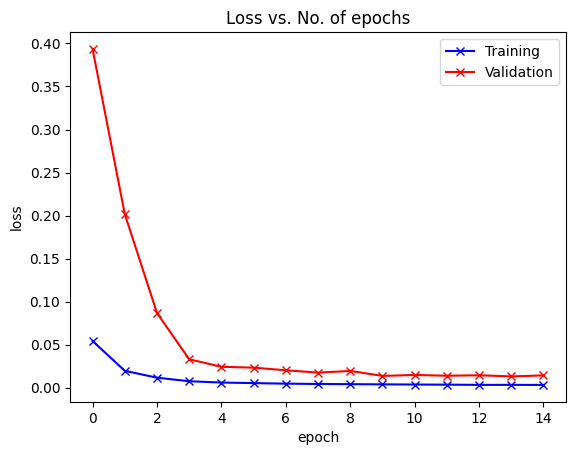

In [21]:
# model selection
model_name = 'rnn'
model = get_model(model_name, model_params)

# optimizer and loss
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

from torch.optim.lr_scheduler import CosineAnnealingLR, ExponentialLR
# scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
scheduler = ExponentialLR(optimizer, gamma=0.95)


rnn_results = train_network(model,
                            optimizer,
                            criterion,
                            scheduler,
                            trainloader,
                            valloader,
                            testloader,
                            num_epochs,
                            input_dim,
                            model_name,
                            dataset
                            )
plot_loss(rnn_results['train_loss'], rnn_results['val_loss'])

Model will be saved to: ./model/^GSPC_lstm.pth
Using device: cpu with seed: 1311



Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1059.93it/s]


check loss:  100000 0.7347893638245632
Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 1/2, Train Loss: 0.1137, Val Loss: 0.7348, Time: 21.31s


Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1123.02it/s]


check loss:  0.7347893638245632 0.4724210207861972
Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 2/2, Train Loss: 0.0307, Val Loss: 0.4724, Time: 21.02s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 520/520 [00:00<00:00, 947.62it/s]


Test Loss: 1.2640


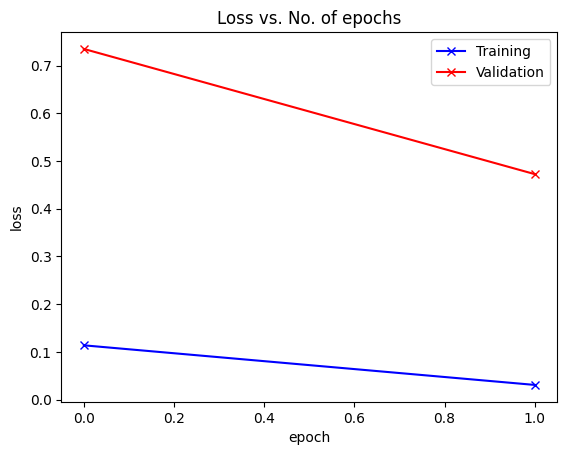

In [21]:
# model selection
model_name = 'lstm'
model = get_model(model_name, model_params)

# optimizer and loss
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

from torch.optim.lr_scheduler import CosineAnnealingLR, ExponentialLR
# scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
scheduler = ExponentialLR(optimizer, gamma=0.95)



lstm_results = train_network(model,
                            optimizer,
                            criterion,
                            scheduler,
                            trainloader,
                            valloader,
                            testloader,
                            num_epochs,
                            input_dim,
                            model_name,
                            dataset
                            )
plot_loss(lstm_results['train_loss'], lstm_results['val_loss'])

Model will be saved to: ./model/^GSPC_gru.pth
Using device: cpu with seed: 1311



Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1334.83it/s]


check loss:  100000 0.42738973911356376
Model improved and saved to ./model/^GSPC_gru.pth
Epoch 1/2, Train Loss: 0.1181, Val Loss: 0.4274, Time: 18.61s


Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1191.00it/s]


check loss:  0.42738973911356376 0.29000253736728765
Model improved and saved to ./model/^GSPC_gru.pth
Epoch 2/2, Train Loss: 0.0218, Val Loss: 0.2900, Time: 19.05s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 520/520 [00:00<00:00, 1081.97it/s]


Test Loss: 0.7971


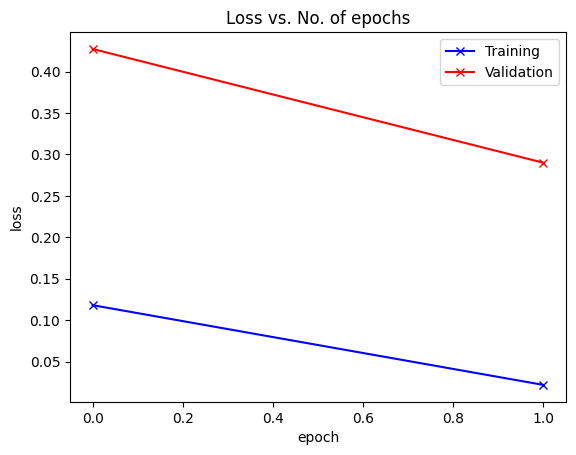

In [22]:
# model selection
model_name = 'gru'
model = get_model(model_name, model_params)

# optimizer and loss
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

from torch.optim.lr_scheduler import CosineAnnealingLR, ExponentialLR
# scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
scheduler = ExponentialLR(optimizer, gamma=0.95)



gru_results = train_network(model,
                            optimizer,
                            criterion,
                            scheduler,
                            trainloader,
                            valloader,
                            testloader,
                            num_epochs,
                            input_dim,
                            model_name,
                            dataset
                            )
plot_loss(gru_results['train_loss'], gru_results['val_loss'])

## Step 06: Evaluation with Testing Set

### Testing on each experiment

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.value, df.prediction),
            'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
            'r2' : r2_score(df.value, df.prediction)}

In [25]:
df_result = {}
df_result['rnn'] = format_predictions(rnn_results['test_pred'], rnn_results['test_actual'], X_test, scaler)
# df_result['lstm'] = format_predictions(lstm_results['test_pred'], lstm_results['test_actual'], X_test, scaler)
# df_result['gru'] = format_predictions(gru_results['test_pred'], gru_results['test_actual'], X_test, scaler)
df_result

{'rnn':                value  prediction
 date                            
 2018-10-18  1.884485    1.782035
 2018-10-19  1.883805    1.767724
 2018-10-22  1.875705    1.749625
 2018-10-23  1.865367    1.755147
 2018-10-24  1.807793    1.750633
 ...              ...         ...
 2020-11-04  2.343672    1.980154
 2020-11-05  2.389280    1.982802
 2020-11-06  2.388593    1.963836
 2020-11-09  2.416539    1.977955
 2020-11-10  2.413157    1.971969
 
 [520 rows x 2 columns]}

In [25]:
result_metrics = {}
result_metrics['rnn']  = calculate_metrics(df_result['rnn'])
result_metrics['lstm']  = calculate_metrics(df_result['lstm'])
result_metrics['gru']  = calculate_metrics(df_result['gru'])
result_metrics

{'rnn': {'mae': 0.6701871,
  'rmse': 0.6858729703611416,
  'r2': -13.578346744804238},
 'lstm': {'mae': 1.0015959,
  'rmse': 1.0152983506972961,
  'r2': -30.945392772464043},
 'gru': {'mae': 0.79200554,
  'rmse': 0.8062454253074324,
  'r2': -19.144451848903287}}

### compare to baseline

In [29]:
from sklearn.linear_model import LinearRegression

def build_baseline_model(df, test_ratio, target_col):
    # X, y = feature_label_split(df, target_col)
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(df, 'value')
    X_t_train = X_train.append(X_val)
    y_t_train = y_train.append(y_val)
    model = LinearRegression()
    model.fit(X_t_train, y_t_train)
    prediction = model.predict(X_test)

    result = pd.DataFrame(y_test)
    result["prediction"] = prediction
    result = result.sort_index()

    return result

df_baseline = build_baseline_model(df_feature, 0.2, 'value')
baseline_metrics = calculate_metrics(df_baseline)
baseline_metrics

Training size: 3632 period 2000-03-28 00:00:00 to 2014-09-04 00:00:00 
Validation size: 1038 period 2014-09-05 00:00:00 to 2018-10-17 00:00:00
test_data size: 520 period 2018-10-18 00:00:00 to 2020-11-10 00:00:00


{'mae': 0.0499754310800479,
 'rmse': 0.07441166750636917,
 'r2': 0.8284056996583051}

### visualize the results

In [27]:
def plot_predictions(df_result, df_baseline):
    data = []
    
    value = go.Scatter(
        x=df_result.index,
        y=df_result.value,
        mode="lines",
        name="values",
        marker=dict(),
        text=df_result.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    baseline = go.Scatter(
        x=df_baseline.index,
        y=df_baseline.prediction,
        mode="lines",
        line={"dash": "dot"},
        name='linear regression',
        marker=dict(),
        text=df_baseline.index,
        opacity=0.8,
    )
    data.append(baseline)
    
    prediction = go.Scatter(
        x=df_result.index,
        y=df_result.prediction,
        mode="lines",
        line={"dash": "dot"},
        name='predictions',
        marker=dict(),
        text=df_result.index,
        opacity=0.8,
    )
    data.append(prediction)
    
    layout = dict(
        title="Predictions vs Actual Values for the dataset",
        xaxis=dict(title="Time", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [30]:
plot_predictions(df_result['rnn'], df_baseline)
plot_predictions(df_result['lstm'], df_baseline)
plot_predictions(df_result['gru'], df_baseline)